<a href="https://colab.research.google.com/github/Mahmudasief/aml-false-positive-reduction-hitl/blob/main/notebooks/02_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Baseline models for AML false positive reduction
# Dataset: Kaggle Credit Card Fraud (European cardholders)
# Goal: establish BEFORE picture (no tuning, no tricks)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

In [ ]:
df = pd.read_csv("/content/creditcard.csv")
df.shape

(284807, 31)

In [ ]:
# Check class imbalance
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [ ]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

X.shape, y.shape

((284807, 30), (284807,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((199364, 30),
 (85443, 30),
 Class
 0    199020
 1       344
 Name: count, dtype: int64,
 Class
 0    85295
 1      148
 Name: count, dtype: int64)

In [ ]:
# Baseline Logistic Regression (NO tuning)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

[[85276    19]
 [   51    97]]
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     85295
           1     0.8362    0.6554    0.7348       148

    accuracy                         0.9992     85443
   macro avg     0.9178    0.8276    0.8672     85443
weighted avg     0.9991    0.9992    0.9991     85443



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Baseline Random Forest (NO tuning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, digits=4))

[[85290     5]
 [   36   112]]
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     85295
           1     0.9573    0.7568    0.8453       148

    accuracy                         0.9995     85443
   macro avg     0.9784    0.8783    0.9225     85443
weighted avg     0.9995    0.9995    0.9995     85443



In [ ]:
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_rf[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

(np.float64(0.0), np.float64(1.0), np.float64(0.0016698851866156386))

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

cost_fp = 5
cost_fn = 500

thresholds = np.linspace(0.0, 1.0, 101)
results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    results.append((t, total_cost, fp, fn, tp))

sorted(results, key=lambda x: x[1])[:10]

[(np.float64(0.05),
  np.int64(11595),
  np.int64(119),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.04),
  np.int64(11790),
  np.int64(158),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.06),
  np.int64(11975),
  np.int64(95),
  np.int64(23),
  np.int64(125)),
 (np.float64(0.03),
  np.int64(12140),
  np.int64(228),
  np.int64(22),
  np.int64(126)),
 (np.float64(0.07),
  np.int64(12390),
  np.int64(78),
  np.int64(24),
  np.int64(124)),
 (np.float64(0.08),
  np.int64(12850),
  np.int64(70),
  np.int64(25),
  np.int64(123)),
 (np.float64(0.25),
  np.int64(13120),
  np.int64(24),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.24),
  np.int64(13125),
  np.int64(25),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.23),
  np.int64(13130),
  np.int64(26),
  np.int64(26),
  np.int64(122)),
 (np.float64(0.22),
  np.int64(13135),
  np.int64(27),
  np.int64(26),
  np.int64(122))]

In [ ]:
best = min(results, key=lambda x: x[1])
best

(np.float64(0.05), np.int64(11595), np.int64(119), np.int64(22), np.int64(126))

In [ ]:
threshold, FP, FN, TP, TN = best

cost_fp = 5
cost_fn = 500

total_cost_best = FP * cost_fp + FN * cost_fn
total_cost_best

np.int64(117475)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# choose a starting threshold
threshold = 0.01

y_pred_thresh = (y_prob_rf >= threshold).astype(int)

confusion_matrix(y_test, y_pred_thresh)

array([[83449,  1846],
       [   20,   128]])

In [ ]:
FP = 1846   # false positives
FN = 20     # false negatives

cost_fp = 5
cost_fn = 500

total_cost = FP * cost_fp + FN * cost_fn
total_cost

19230

In [ ]:
# Baseline RF cost at default threshold (0.5)

FP_base = 5
FN_base = 36

cost_fp = 5
cost_fn = 500

total_cost_base = FP_base * cost_fp + FN_base * cost_fn
total_cost_base

18025

In [18]:
best_threshold = 0.05

y_pred_best = (y_prob_rf >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test, y_pred_best)

array([[85176,   119],
       [   22,   126]])

In [19]:
FP = 119
FN = 22

cost_fp = 5
cost_fn = 500

total_cost_best = FP * cost_fp + FN * cost_fn
total_cost_best

11595

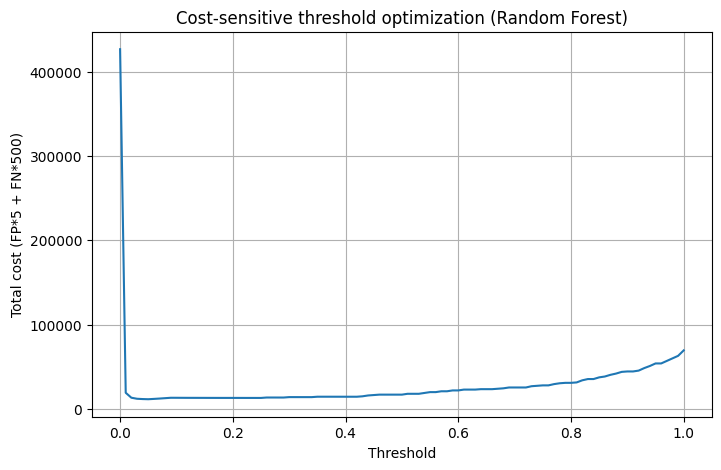

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cost_fp = 5
cost_fn = 500

thresholds = np.linspace(0, 1, 101)
costs = []
fps = []
fns = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)
    fps.append(fp)
    fns.append(fn)

plt.figure(figsize=(8,5))
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Total cost (FP*5 + FN*500)")
plt.title("Cost-sensitive threshold optimization (Random Forest)")
plt.grid(True)

plt.savefig("/content/cost_vs_threshold_rf.png", dpi=150, bbox_inches="tight")
plt.show()

In [22]:
# Find optimal threshold numerically
min_cost = min(costs)
optimal_threshold = thresholds[np.argmin(costs)]

min_cost, optimal_threshold

(np.int64(11595), np.float64(0.05))

In [23]:
from sklearn.metrics import confusion_matrix

t = 0.05
y_pred_t = (y_prob_rf >= t).astype(int)

cm = confusion_matrix(y_test, y_pred_t)
cm

array([[85176,   119],
       [   22,   126]])

In [25]:
TN, FP, FN, TP = cm.ravel()

cost_fp = 5
cost_fn = 500

total_cost = FP*cost_fp + FN*cost_fn

print("=== Random Forest @ threshold = 0.05 ===")
print("Confusion matrix [[TN, FP],[FN, TP]]:")
print(cm)
print(f"TN={TN}, FP={FP}, FN={FN}, TP={TP}")

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Precision (fraud) = {precision:.4f}")
print(f"Recall (fraud)    = {recall:.4f}")
print(f"Total cost        = {total_cost}")

=== Random Forest @ threshold = 0.05 ===
Confusion matrix [[TN, FP],[FN, TP]]:
[[85176   119]
 [   22   126]]
TN=85176, FP=119, FN=22, TP=126
Precision (fraud) = 0.5143
Recall (fraud)    = 0.8514
Total cost        = 11595


In [26]:
import pandas as pd

summary = pd.DataFrame([{
    "model": "RandomForest",
    "best_threshold": 0.05,
    "false_positives": 119,
    "false_negatives": 22,
    "total_cost": 11595
}])

summary

,model,best_threshold,false_positives,false_negatives,total_cost
0,RandomForest,0.05,119,22,11595


In [29]:
summary.to_csv("/content/best_threshold_summary.csv", index=False)